# Fish total, herbivore, planktivore, and piscivore abundance model for Chagos Rats

The models here will be run in [Python](https://www.python.org), using the [PyMC3 package](https://github.com/pymc-devs/pymc3).

### Data wrangling

The first step is to instantiate the various python packages needed for the analysis:

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import matplotlib as mp
import sqlite3
import os
import theano as th

# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import age and growth data
xdata = pd.read_csv('Chagos_rats_birds_UVC_data.csv')
xdata.head()

,Atoll,Island,Treatment,Transect,Area,Family,Species,Function,Structure,Coral_cover,Length,Biomass,Abundance
0,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Ctenochaetus_striatus,Herbivore,2.0,12.67,13,4.0,66.7
1,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Naso_brachycentron,Herbivore,2.0,12.67,33,49.6,66.7
2,Great_Chagos_Bank,Eagle,Rats,1,150,Scaridae,Chlorurus_sordidus,Herbivore,2.0,12.67,13,3.3,66.7
3,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Acanthurus_nigrofuscus,Herbivore,2.0,12.67,13,4.1,66.7
4,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Acanthurus_nigrofuscus,Herbivore,2.0,12.67,12,3.2,66.7


In [3]:
# Generate new index
ydata = xdata.set_index(['Atoll', 'Island', 'Transect'])
ydata.head()

Treatment  Area        Family  \
Atoll             Island Transect                                 
Great_Chagos_Bank Eagle  1             Rats   150  Acanthuridae   
                         1             Rats   150  Acanthuridae   
                         1             Rats   150      Scaridae   
                         1             Rats   150  Acanthuridae   
                         1             Rats   150  Acanthuridae   

                                                  Species   Function  \
Atoll             Island Transect                                      
Great_Chagos_Bank Eagle  1          Ctenochaetus_striatus  Herbivore   
                         1             Naso_brachycentron  Herbivore   
                         1             Chlorurus_sordidus  Herbivore   
                         1         Acanthurus_nigrofuscus  Herbivore   
                         1         Acanthurus_nigrofuscus  Herbivore   

                                   Structure  Coral_cover  Length  Biomass  \
Atoll             Island Transect                                            
Great_Chagos_Bank Eagle  1               2.0        12.67      13      4.0   
                         1               2.0        12.67      33     49.6   
                         1               2.0        12.67      13      3.3   
                         1               2.0        12.67      13      4.1   
                         1               2.0        12.67      12      3.2   

                                   Abundance  
Atoll             Island Transect             
Great_Chagos_Bank Eagle  1              66.7  
                         1              66.7  
                         1              66.7  
                         1              66.7  
                         1              66.7

In [4]:
# Split data frames into functional groups
Herbs = xdata[xdata.Function=='Herbivore']
Plank = xdata[xdata.Function=='Planktivore']
Pisci = xdata[xdata.Function=='Piscivore']
Mixed = xdata[xdata.Function=='Mixed-diet']
Corali = xdata[xdata.Function=='Corallivore']
Inverti = xdata[xdata.Function=='Invertivore']
Total = xdata

In [5]:
# Grab summarized data for modelling
# Responses
h_lbiomass = np.log(Herbs.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel())
pl_lbiomass = np.log(Plank.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
pi_lbiomass = np.log(Pisci.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
mi_lbiomass = np.log(Mixed.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
c_lbiomass = np.log(Corali.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
i_lbiomass = np.log(Inverti.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
lbiomass = np.log(Total.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel())
rdata = [h_lbiomass,pl_lbiomass,pi_lbiomass,mi_lbiomass,c_lbiomass,i_lbiomass]
Res_names = ['Herbivores','Planktivores','Piscivores','Mixed-diet','Corallivores','Invertivores']

# Covariates
structure = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Structure'].unique().ravel()])
struct = structure-np.mean(structure)
hc = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Coral_cover'].unique().ravel()])
treatment = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Treatment'].unique().ravel()])
It = (treatment=='Rats')*1

# Hierarchy
Atoll_, Island_, Transect_ = np.array([np.array(x) for x in ydata.index.unique()]).T
Atoll,Ia = subindexall(Atoll_,Island_)
natoll = len(Atoll)
Island,Is = indexall(Island_)
nisland = len(Island)

In [6]:
# Check correlation between structure and hard coral
np.corrcoef(structure,hc)

array([[1.        , 0.19640874],
       [0.19640874, 1.        ]])

# Total biomass model

Set up data loop

In [7]:
# Shared data trick from https://github.com/pymc-devs/pymc3/issues/1825
shared_data = th.shared(rdata[0], borrow=True)

In [8]:
Model = pm.Model()

with Model:
    # Global estimate
    γ0 = pm.Normal('Mean_biomass', 0, 1000)
    # Variation among islands
    σ0 = pm.Uniform('Island_SD', 0, 100)
    
    # Transect-level intercepts
    β0 = pm.Normal('Island_biomass', γ0, σ0, shape=nisland)
    β1 = pm.Normal('Rat_effect', 0, 1000)
    β2 = pm.Normal('Structure', 0, 1000)
    β3 = pm.Normal('Hard_coral', 0, 1000)

    # Mean model
    μ = β0[Is]+β1*It+β2*struct+β3*hc
    
    # Observation error
    σ1 = pm.Uniform('Obs_sigma', lower=0., upper=100.)
    
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ1, observed=shared_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████▉| 10460/10500 [00:31<00:00, 327.23it/s]/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 764 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 10500/10500 [00:32<00:00, 327.21it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is depreca

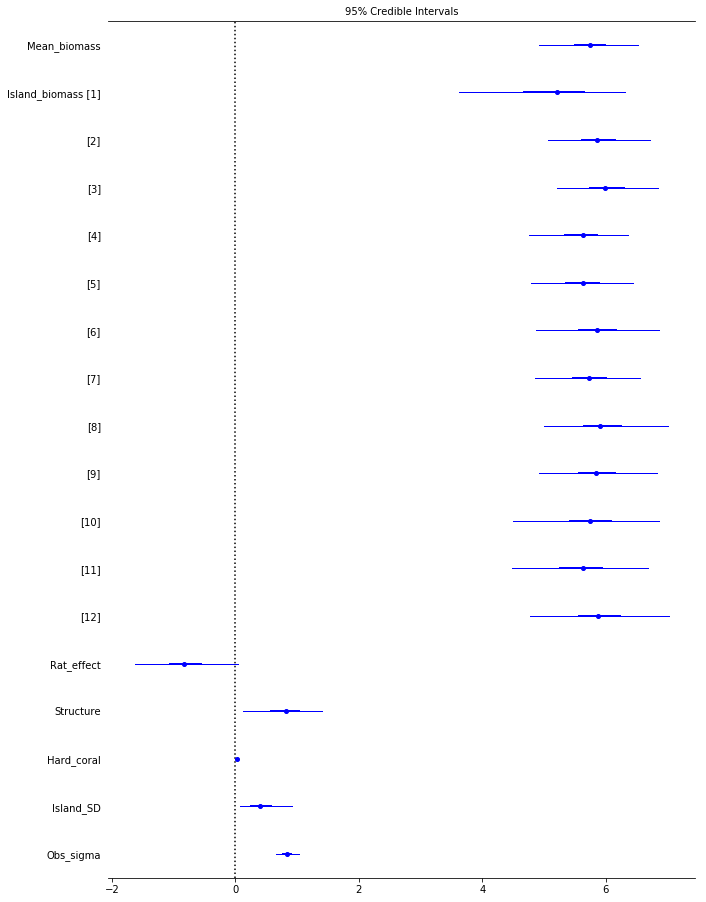

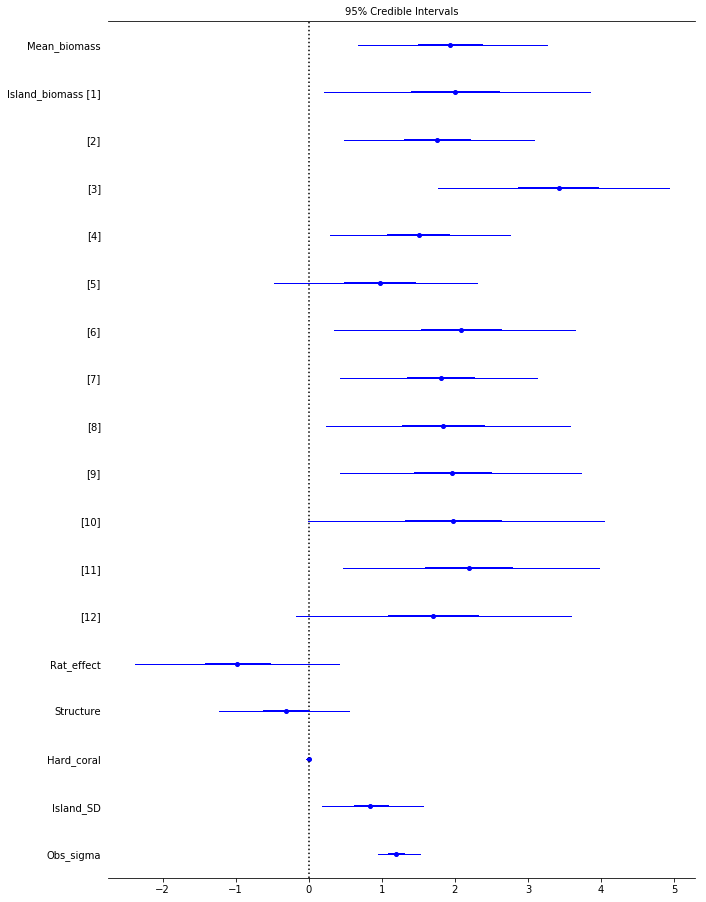

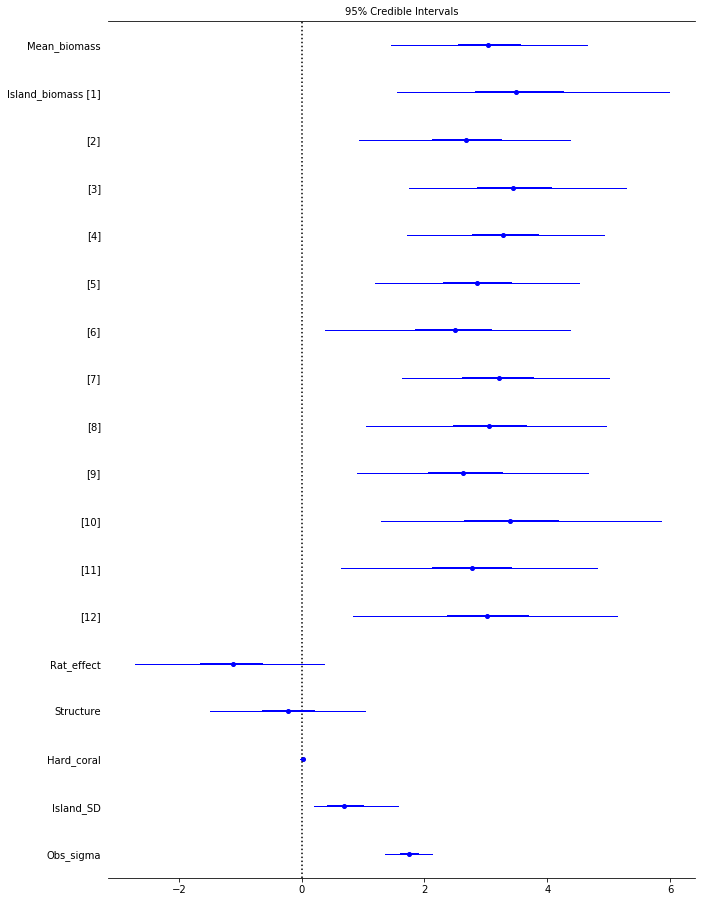

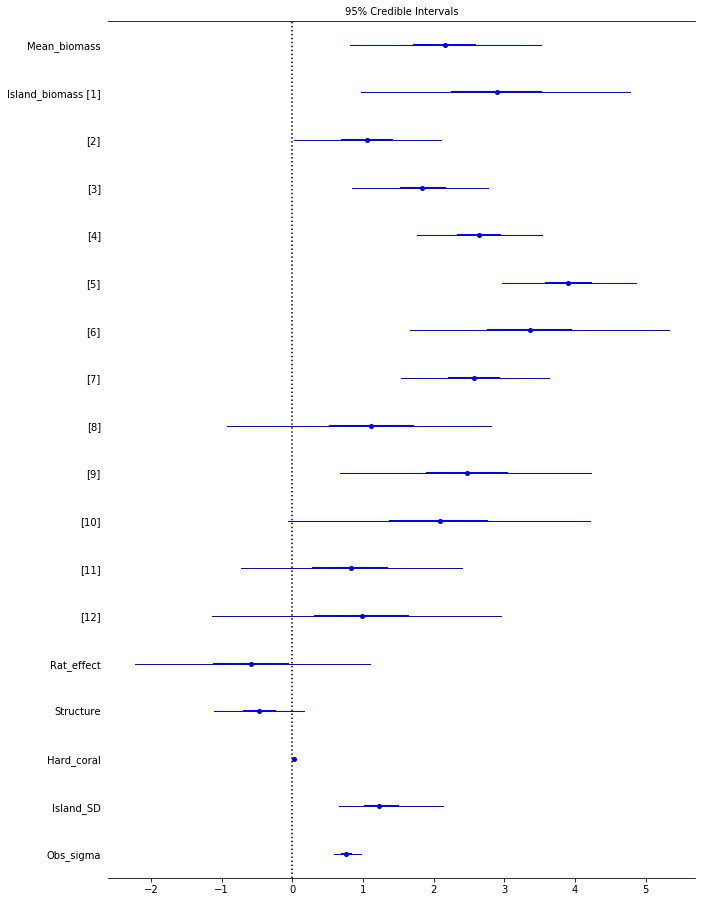

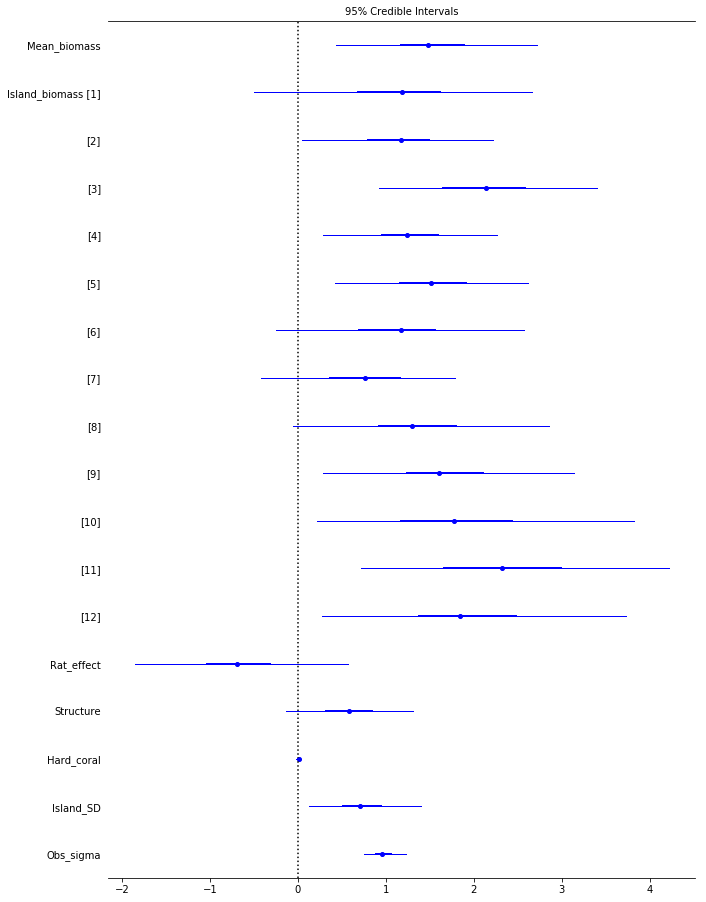

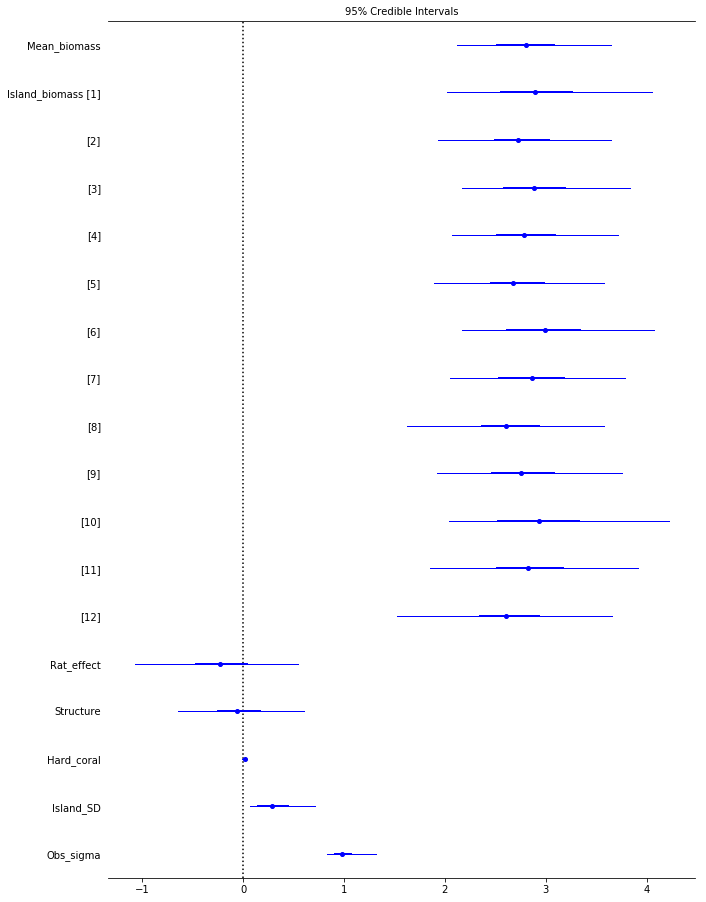

In [9]:
# Iterate over datasets
for i in range(len(Res_names)):
    # Update new response variable
    shared_data.set_value(rdata[i])
    # Sampling
    with Model:
        # Draw samples
        trace = pm.sample(10000)
    out = pm.backends.tracetab.trace_to_dataframe(trace)
    out.to_csv(Res_names[i]+'_results.csv')
    #fig, ax = plt.subplots()
    pm.traceplot(trace)
    plt.savefig(Res_names[i]+'_traceplot.pdf')
    pm.forestplot(trace)
    plt.savefig(Res_names[i]+'_forestplot.pdf');